In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.api import VAR, DynamicVAR, VARMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyramid.arima import auto_arima

In [2]:
nights = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv', index_col='date', parse_dates=['date'], 
                          usecols=[*range(1, 15)])
temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
gdp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])

# df with endog data for training set
endog_PDL = pd.concat([nights, gdp], axis=1)
endog_PDL = endog_PDL.dropna()
endog_PDL = endog_PDL[['nights_PDL','gdp_PDL']]

# df with exog data for training set
exog_PDL = pd.concat([temp, daysoff], axis=1)
exog_PDL = exog_PDL[['avgtemp_PDL','daysoff']]     # DF format for seasonal decompose

# df with nights only for testing set
nights_PDL = nights[['nights_PDL']]

Years of training data: ['2010', '2011']
Predicted year: 2012-01-01
VAR lag order: 11
RMSE test: 158.3693398179878
MAE test: 137.9436152074319
-------
Years of training data: ['2010', '2011', '2012']
Predicted year: 2013-01-01
VAR lag order: 11
RMSE test: 170.59006305157573
MAE test: 128.98175484299273
-------
Years of training data: ['2010', '2011', '2012', '2013']
Predicted year: 2014-01-01
VAR lag order: 11
RMSE test: 105.33880378773163
MAE test: 93.34032825346442
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014']
Predicted year: 2015-01-01
VAR lag order: 11
RMSE test: 53.50897683776326
MAE test: 43.72277753599582
-------
Years of training data: ['2010', '2011', '2012', '2013', '2014', '2015']
Predicted year: 2016-01-01
VAR lag order: 11
RMSE test: 40.87547840705688
MAE test: 31.074626094847577
-------


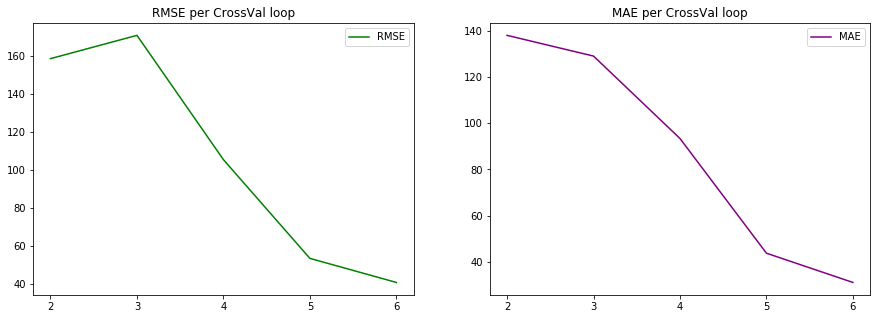

In [4]:
# Make sure to fill these in for each region! Input data must have datetime as index

input_data = endog_PDL         # dataframe-type dataset # Endog
target = nights_PDL           # dataframe-type dataset
exog = exog_PDL
start_year = '2010-01-01'     # date as string

all_mae = []
all_rmse = []
years_data = []

for index in range(2012, 2017):
    end_year = str(index)+'-01-01'
    predict_year = str(index+1)+'-01-01'
    
    training_period = (input_data.index>=start_year)&(input_data.index<end_year) 
    testing_period = (target.index>=end_year)&(target.index<predict_year)
    
    train_data = input_data[training_period]
    test_data = np.array(target[testing_period]) # Array format to calculate errors at the end
        
    exog_train_data = exog[(exog.index>=start_year)&(exog.index<end_year) ]
    exog_future_data = exog[(exog.index>=end_year)&(exog.index<predict_year)]
    
    # --------Seasonal decompose----------
    
    # - IMPORTANT - Change model (multiplicative or additive) based on season type of nights
    decomposed_data = seasonal_decompose(train_data, model='additive', extrapolate_trend='freq')  

    seasonal_data, trend_data, residual_data = decomposed_data.seasonal, decomposed_data.trend, decomposed_data.resid
    
    exog_resid = seasonal_decompose(exog_train_data, model='additive', extrapolate_trend='freq')
    exog_resid_data = exog_resid.resid
    
    # ---------Seasonal prediction (Same as last year of training data)---------

    # Duplicate last year's seasonal data
    seasonal_forecast = seasonal_data[(seasonal_data.index>=start_year)&(seasonal_data.index<end_year)]
    
    # Forecasted DF without datetime index and only 12 months to be able to recompose later
    # - IMPORTANT - Replace nights_PAC below with column name for your region
    seasonal_forecast_df = pd.DataFrame(seasonal_forecast.nights_PDL.values[-12:])
    
    # --------Trend prediction (Linear Holt)----------
    
     # ARIMA model (w/ auto parameters) on nights trend
    trend_model = auto_arima(trend_data.nights_PDL, 
                             start_p=0, start_q=0, max_p=20, max_q=20, m=12, 
                             start_P=0, max_P=20, seasonal=False, d=1, D=1, 
                             trace=False, error_action='ignore', suppress_warnings=True, 
                             stepwise=True, random=True, random_state=42) 
    
        # If using Holt: Holt(trend_data['nights_'+region_code]).fit(optimized=True)
    
    # Predict 12 months of trend
    trend_forecast = trend_model.predict(n_periods=12)
    
        # If using Holt: trend_model.predict(start=0, end=11)
    
    # Forecasted DF without datetime index to be able to recompose later
    trend_forecast_df = pd.DataFrame(trend_forecast) 
    
    # --------Residual prediction (VAR)----------

    # VAR model: Don't use maxlags, use specific lags in fit argument below
    resid_model = VAR(endog=residual_data, exog=exog_resid_data, dates=residual_data.index)
    # - IMPORTANT - Replace lag number in fit below with desired lags
    resid_results = resid_model.fit(11, trend='nc')
    
    lag_order = resid_results.k_ar

    # Forecasted DF without datetime index to be able to recompose later
    resid_forecast_df = pd.DataFrame(resid_results.forecast(residual_data.values[-lag_order:], 12, 
                                                            exog_future=exog_future_data))

    # --------Recomposing results----------
    # - IMPORTANT - Addition if additive series /// Multiplication if multiplicative series
    forecast = seasonal_forecast_df[0] + trend_forecast_df[0] + resid_forecast_df[0]
    
    
    # --------Calculated error measures for each CV step----------
    rmse_test = np.sqrt(mean_squared_error(test_data, forecast))
    mae_test = mean_absolute_error(test_data, forecast)
    
    all_rmse.append(rmse_test)
    all_mae.append(mae_test)
    
    years_data.append(end_year)
    
    print('Years of training data:', train_data.index.strftime('%Y').unique().tolist())
    print('Predicted year:', end_year)
    print('VAR lag order:', lag_order)
    print('RMSE test:', rmse_test)
    print('MAE test:', mae_test)
    print('-------')

# Error measures per CrossVal loop (number of years of training data used)
years_training = list(range(2,7))

fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].plot(years_training, all_rmse, label='RMSE', color='green')
axes[0].set_xticks(years_training)
axes[0].set_title('RMSE per CrossVal loop')
axes[0].legend()

axes[1].plot(years_training, all_mae, label='MAE', color='purple')
axes[1].set_xticks(years_training)
axes[1].set_title('MAE per CrossVal loop')
axes[1].legend();

## Errors
- Missing 2016 GDP data in endog so cannot predict 2017 data: Can potentially repeat 2016 data or do forecasting if necessary
- [**Resolved**] Gigantic error when predicting 2014 using 2010-2013 data --- Resolved by specifying "extrapolate_trend" when calling seasonal_decompose